# Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

# All the libraries we will need

In [ ]:
%load_ext tensorboard

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import joblib
import subprocess
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

2025-05-09 13:11:09.302311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746796269.476767   40397 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746796269.538318   40397 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 13:11:09.886511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 70% of memory on the first GPU
    def get_gpu_memory():
        command = "nvidia-smi --query-gpu=memory.free --format=csv"
        memory_free_info = subprocess.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
        return memory_free_values
    
    mem = get_gpu_memory()
    mem = int(0.7*mem[0])
    
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem)])
        print(f"Allocated a tensorflow object 70% ({mem}MB) of memory for this standalone notebook.")
    except:
        print("Failed to allocate GPU memory")

Allocated a tensorflow object 70% (2774MB) of memory for this standalone notebook.


### Set Global Parameters

In [2]:
features_extract = 39
joblib.dump(features_extract, "features.pkl")
class_names = ["Asthma", "Bronchiectasis", "Bronchiolitis","COPD","Healthy","LRTI","Pneumonia","URTI"]
joblib.dump(class_names, "class_names.pkl")

['class_names.pkl']

### The dataset includes a CSV file

In [8]:
df = pd.read_csv('Data/Respiratory_Sound_Database/patient_diagnosis.csv', names=['id','disease'])
df.head()

,id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


### Get the total disease and percentage values

In [9]:
print(df.disease.value_counts())

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64


In [10]:
print(df.disease.value_counts(normalize=True)*100)

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


### create files loading variables

In [11]:
path='Data/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [12]:
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

### Plots

<Axes: xlabel='count', ylabel='disease'>

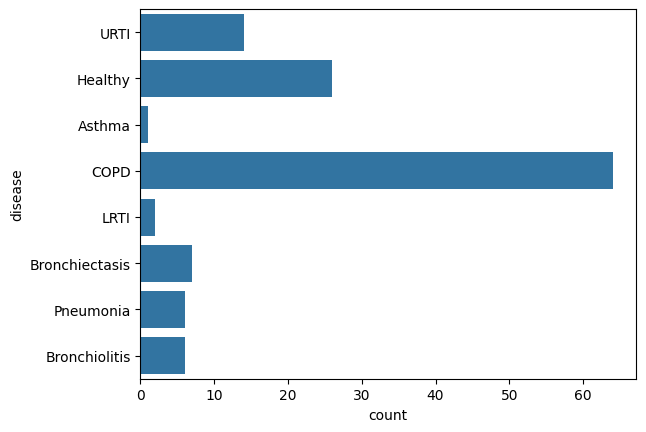

In [13]:
sns.countplot(df.disease)

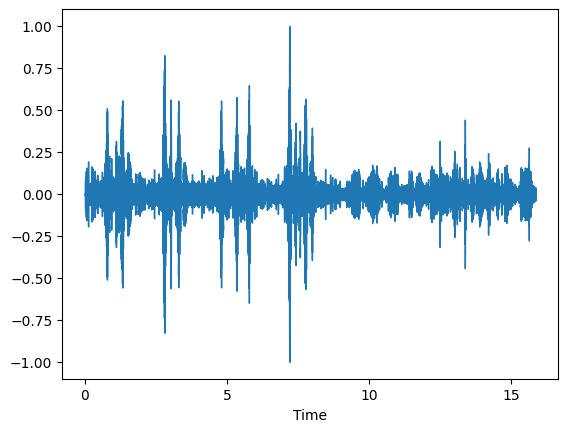

In [14]:
def show_audio_wave(audio_file):
    y,sr = librosa.load(audio_file)
    librosa.display.waveshow(y,sr=sr)

show_audio_wave("Data/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav")

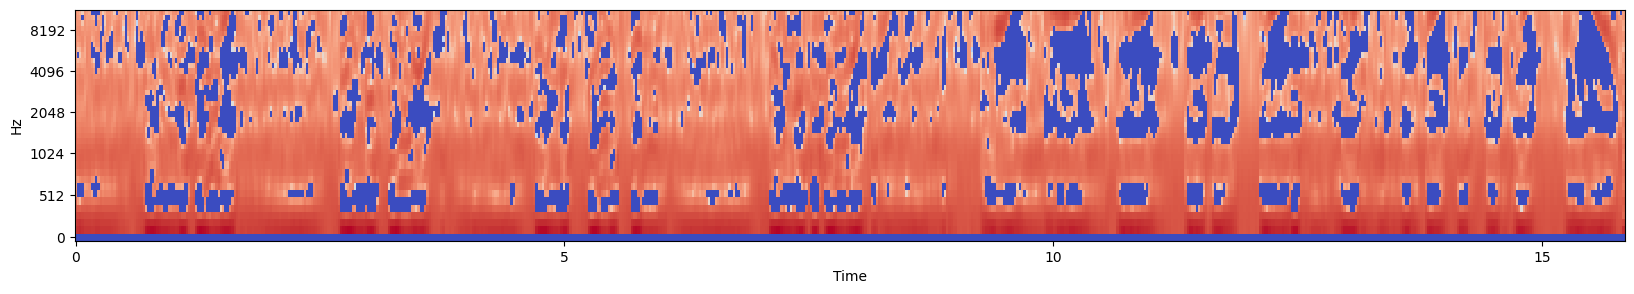

In [15]:
def audio_show_features(audio_file):
    y,sr = librosa.load(audio_file)
    y = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=39)
    plt.figure(figsize=(20,3))
    librosa.display.specshow(librosa.power_to_db(y),x_axis="time",y_axis="mel")

audio_show_features("Data/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav")

### Create data loading functions

Data must be artificially augmented for better generalization

In [16]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data_stretched = librosa.effects.time_stretch(data, rate=rate)
    return data_stretched

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [17]:
def mfcc_features_augmented(df, dir, features=39):
    # we will augment our sounds by adding noise, shifting data, stretching it, and pitch shifting
    # 39 is an arbitrary number that i selected based on information online. it may aswell be wrong
    X = []
    y = []
    
    COPD = []
    copd_count = 0
    

    # we will augment the training data with 4 additional functions, thus
    # leaving us with 5 times the original data
    # we have a large amount of training data on COPD. Hence we will not augment it. copd has a lot of data for single patient repeated. so we will filter extra data
    # we have substantial data on Healthy lungs. so we will augment it in 2 times
    # instead of 4
    # we have very low data on LRTI and Asthama, so we make more augmentations

    for sdir in os.listdir(dir):
        if sdir[-3:] == "wav":
            p = list(df[df['id'] == int(sdir[:3])]['disease'])[0]
            if p == "COPD":
                # data_x, sampling_rate = librosa.load(dir+sdir)
                # mfccs = np.mean(librosa.feature.mfcc(
                #     y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
                # X.append(mfccs)
                # y.append(p)
                
                if (sdir[:6] in COPD) and copd_count<1:
                    data_x, sampling_rate = librosa.load(dir+sdir)
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(sdir[:6])
                    copd_count+=1
                    X.append(mfccs)
                    y.append(list(df[df['id']==int(sdir[:3])]['disease'])[0])

                if (sdir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir+sdir)
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(sdir[:6])
                    copd_count=0
                    X.append(mfccs)
                    y.append(list(df[df['id']==int(sdir[:3])]['disease'])[0])


            elif p == "Healthy":
                data_x, sampling_rate = librosa.load(dir+sdir)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = add_noise(data_x, 0.0025)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = stretch(data_x, 0.85)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)
            
            elif p=="Asthma" or p=="LRTI":
                data_x, sampling_rate = librosa.load(dir+sdir)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = add_noise(data_x, 0.0025)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = stretch(data_x, 0.85)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = shift(data_x, 1750)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = pitch_shift(data_x, 2.5)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)
                
                data_aug = add_noise(data_x, 0.0038)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = stretch(data_x, 0.728)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = shift(data_x, 2550)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = pitch_shift(data_x, 3.2)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)
                
                data_aug = shift(data_x, 550)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = pitch_shift(data_x, 0.85)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

            else:
                data_x, sampling_rate = librosa.load(dir+sdir)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = add_noise(data_x, 0.0025)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = stretch(data_x, 0.85)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = shift(data_x, 1750)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = stretch(data_x, 1.15)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = add_noise(data_x, 0.0035)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)

                data_aug = pitch_shift(data_x, 2.5)
                mfccs = np.mean(librosa.feature.mfcc(
                    y=data_aug, sr=sampling_rate, n_mfcc=features).T, axis=0)
                X.append(mfccs)
                y.append(p)
    
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [18]:
path = "Data/Respiratory_Sound_Database/audio_and_txt_files/"
X, y = mfcc_features_augmented(df, path, features=features_extract)

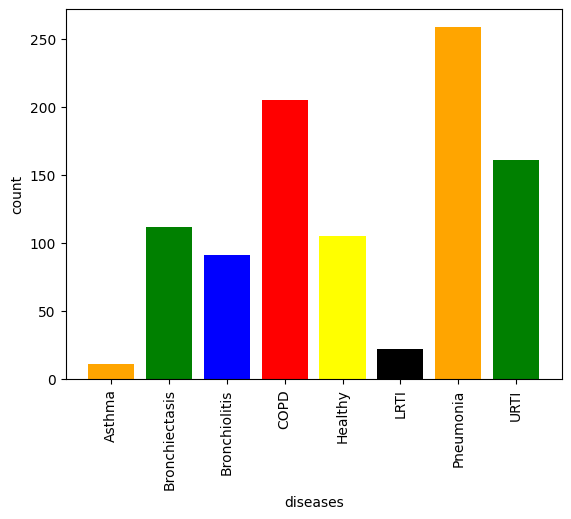

{'Asthma': 11, 'Bronchiectasis': 112, 'Bronchiolitis': 91, 'COPD': 205, 'Healthy': 105, 'LRTI': 22, 'Pneumonia': 259, 'URTI': 161}


In [19]:
def augmented_percentage_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    data = dict(zip(unique, counts))
    courses = list(data.keys())
    values = list(data.values())

    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'])

    plt.xlabel("diseases")
    plt.ylabel("count")
    plt.xticks(rotation=90)
    plt.show()
    print (data)

augmented_percentage_counts(y)

In [20]:
print(len(y))
print(list(set(y)))

y[:10]

966
['Bronchiectasis', 'COPD', 'Asthma', 'Healthy', 'URTI', 'LRTI', 'Bronchiolitis', 'Pneumonia']


array(['URTI', 'URTI', 'URTI', 'URTI', 'URTI', 'URTI', 'URTI', 'URTI',
       'URTI', 'URTI'], dtype='<U14')

Need to convert the strings into numeric labels. As multiclass classification,
use dummies.

In [21]:
y = y.reshape(y.shape[0],1)
y = np.where(y == class_names[0],np.array([1,0,0,0,0,0,0,0]).reshape(1,8) , y)
y = np.where(y == class_names[1],np.array([0,1,0,0,0,0,0,0]).reshape(1,8) , y)
y = np.where(y == class_names[2],np.array([0,0,1,0,0,0,0,0]).reshape(1,8) , y)
y = np.where(y == class_names[3],np.array([0,0,0,1,0,0,0,0]).reshape(1,8) , y)
y = np.where(y == class_names[4],np.array([0,0,0,0,1,0,0,0]).reshape(1,8) , y)
y = np.where(y == class_names[5],np.array([0,0,0,0,0,1,0,0]).reshape(1,8) , y)
y = np.where(y == class_names[6],np.array([0,0,0,0,0,0,1,0]).reshape(1,8) , y)
y = np.where(y == class_names[7],np.array([0,0,0,0,0,0,0,1]).reshape(1,8) , y)

y = y.astype('float64')

Train test

In [84]:
mfcc_train, mfcc_test, labels_train, labels_test = train_test_split(X, y, test_size=0.1, random_state=17, shuffle=True)
mfcc_train, mfcc_val, labels_train, labels_val = train_test_split(mfcc_train, labels_train, test_size=0.1, random_state=17)
print("Training set shape:", mfcc_train.shape, labels_train.shape)
print("Validation set shape:", mfcc_val.shape, labels_val.shape)
print("Test set shape:", mfcc_test.shape, labels_test.shape)

Training set shape: (782, 39) (782, 8)
Validation set shape: (87, 39) (87, 8)
Test set shape: (97, 39) (97, 8)


In [85]:
# add asthma to fix imbalance in testing set
cnt = 0
for i in range(len(mfcc_train)):
    if class_names[np.argmax(labels_train[i])] == "Asthma":
        mfcc_test = np.append(mfcc_test, [mfcc_train[i]], axis=0)
        labels_test = np.append(labels_test, [labels_train[i]], axis=0)
        cnt += 1
    
        # print(labels_train[i])
        
        if cnt>5:
            break

In [87]:
mfcc_train = np.expand_dims(mfcc_train,axis=1)
mfcc_val = np.expand_dims(mfcc_val,axis=1)
mfcc_test = np.expand_dims(mfcc_test,axis=1)

labels_train = np.expand_dims(labels_train,axis=1)
labels_val = np.expand_dims(labels_val,axis=1)
labels_test = np.expand_dims(labels_test,axis=1)

## CNN-LSTM Model building

In [24]:
ModInput = Input(shape=(1,features_extract))

# CNN Layer
model_conv = Conv1D(64, kernel_size=5, padding='same', activation='relu')(ModInput)
model_conv = Conv1D(256, kernel_size=2, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, padding='same')(model_conv)
model_conv = BatchNormalization()(model_conv)

# LSTM Layer
model_lstm = LSTM(256, return_sequences=True, activation='tanh')(model_conv)
model_lstm_bidirectional = Bidirectional(LSTM(256, return_sequences=True, activation='tanh'))(model_conv)

# GRU Layer
model_gru = GRU(256, return_sequences=True, activation='tanh')(model_conv)
model_gru_bidirectional = Bidirectional(GRU(256, return_sequences=True, activation='tanh'))(model_conv)

# Concatenate
model_final = concatenate([model_conv, model_lstm, model_lstm_bidirectional, model_gru, model_gru_bidirectional])

# dense
model_final = Dense(128, activation='relu')(model_final)
model_final = Dense(32, activation='relu')(model_final)
model_final = Dense(8, activation='softmax')(model_final)

Respi_model = Model(inputs=ModInput, outputs = model_final)
Respi_model.summary()

I0000 00:00:1746796413.648469   40397 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2774 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 39)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 64)     │     12,544 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 256)    │     33,024 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 256)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 256)    │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 256)    │    525,312 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1, 512)    │  1,050,624 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1, 256)    │    394,752 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1, 512)    │    789,504 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1792)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ lstm[0][0],       │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ gru[0][0],        │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 128)    │    229,504 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 32)     │      4,128 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 8)      │        264 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,040,680 (11.60 MB)

 Trainable params: 3,040,168 (11.60 MB)

 Non-trainable params: 512 (2.00 KB)

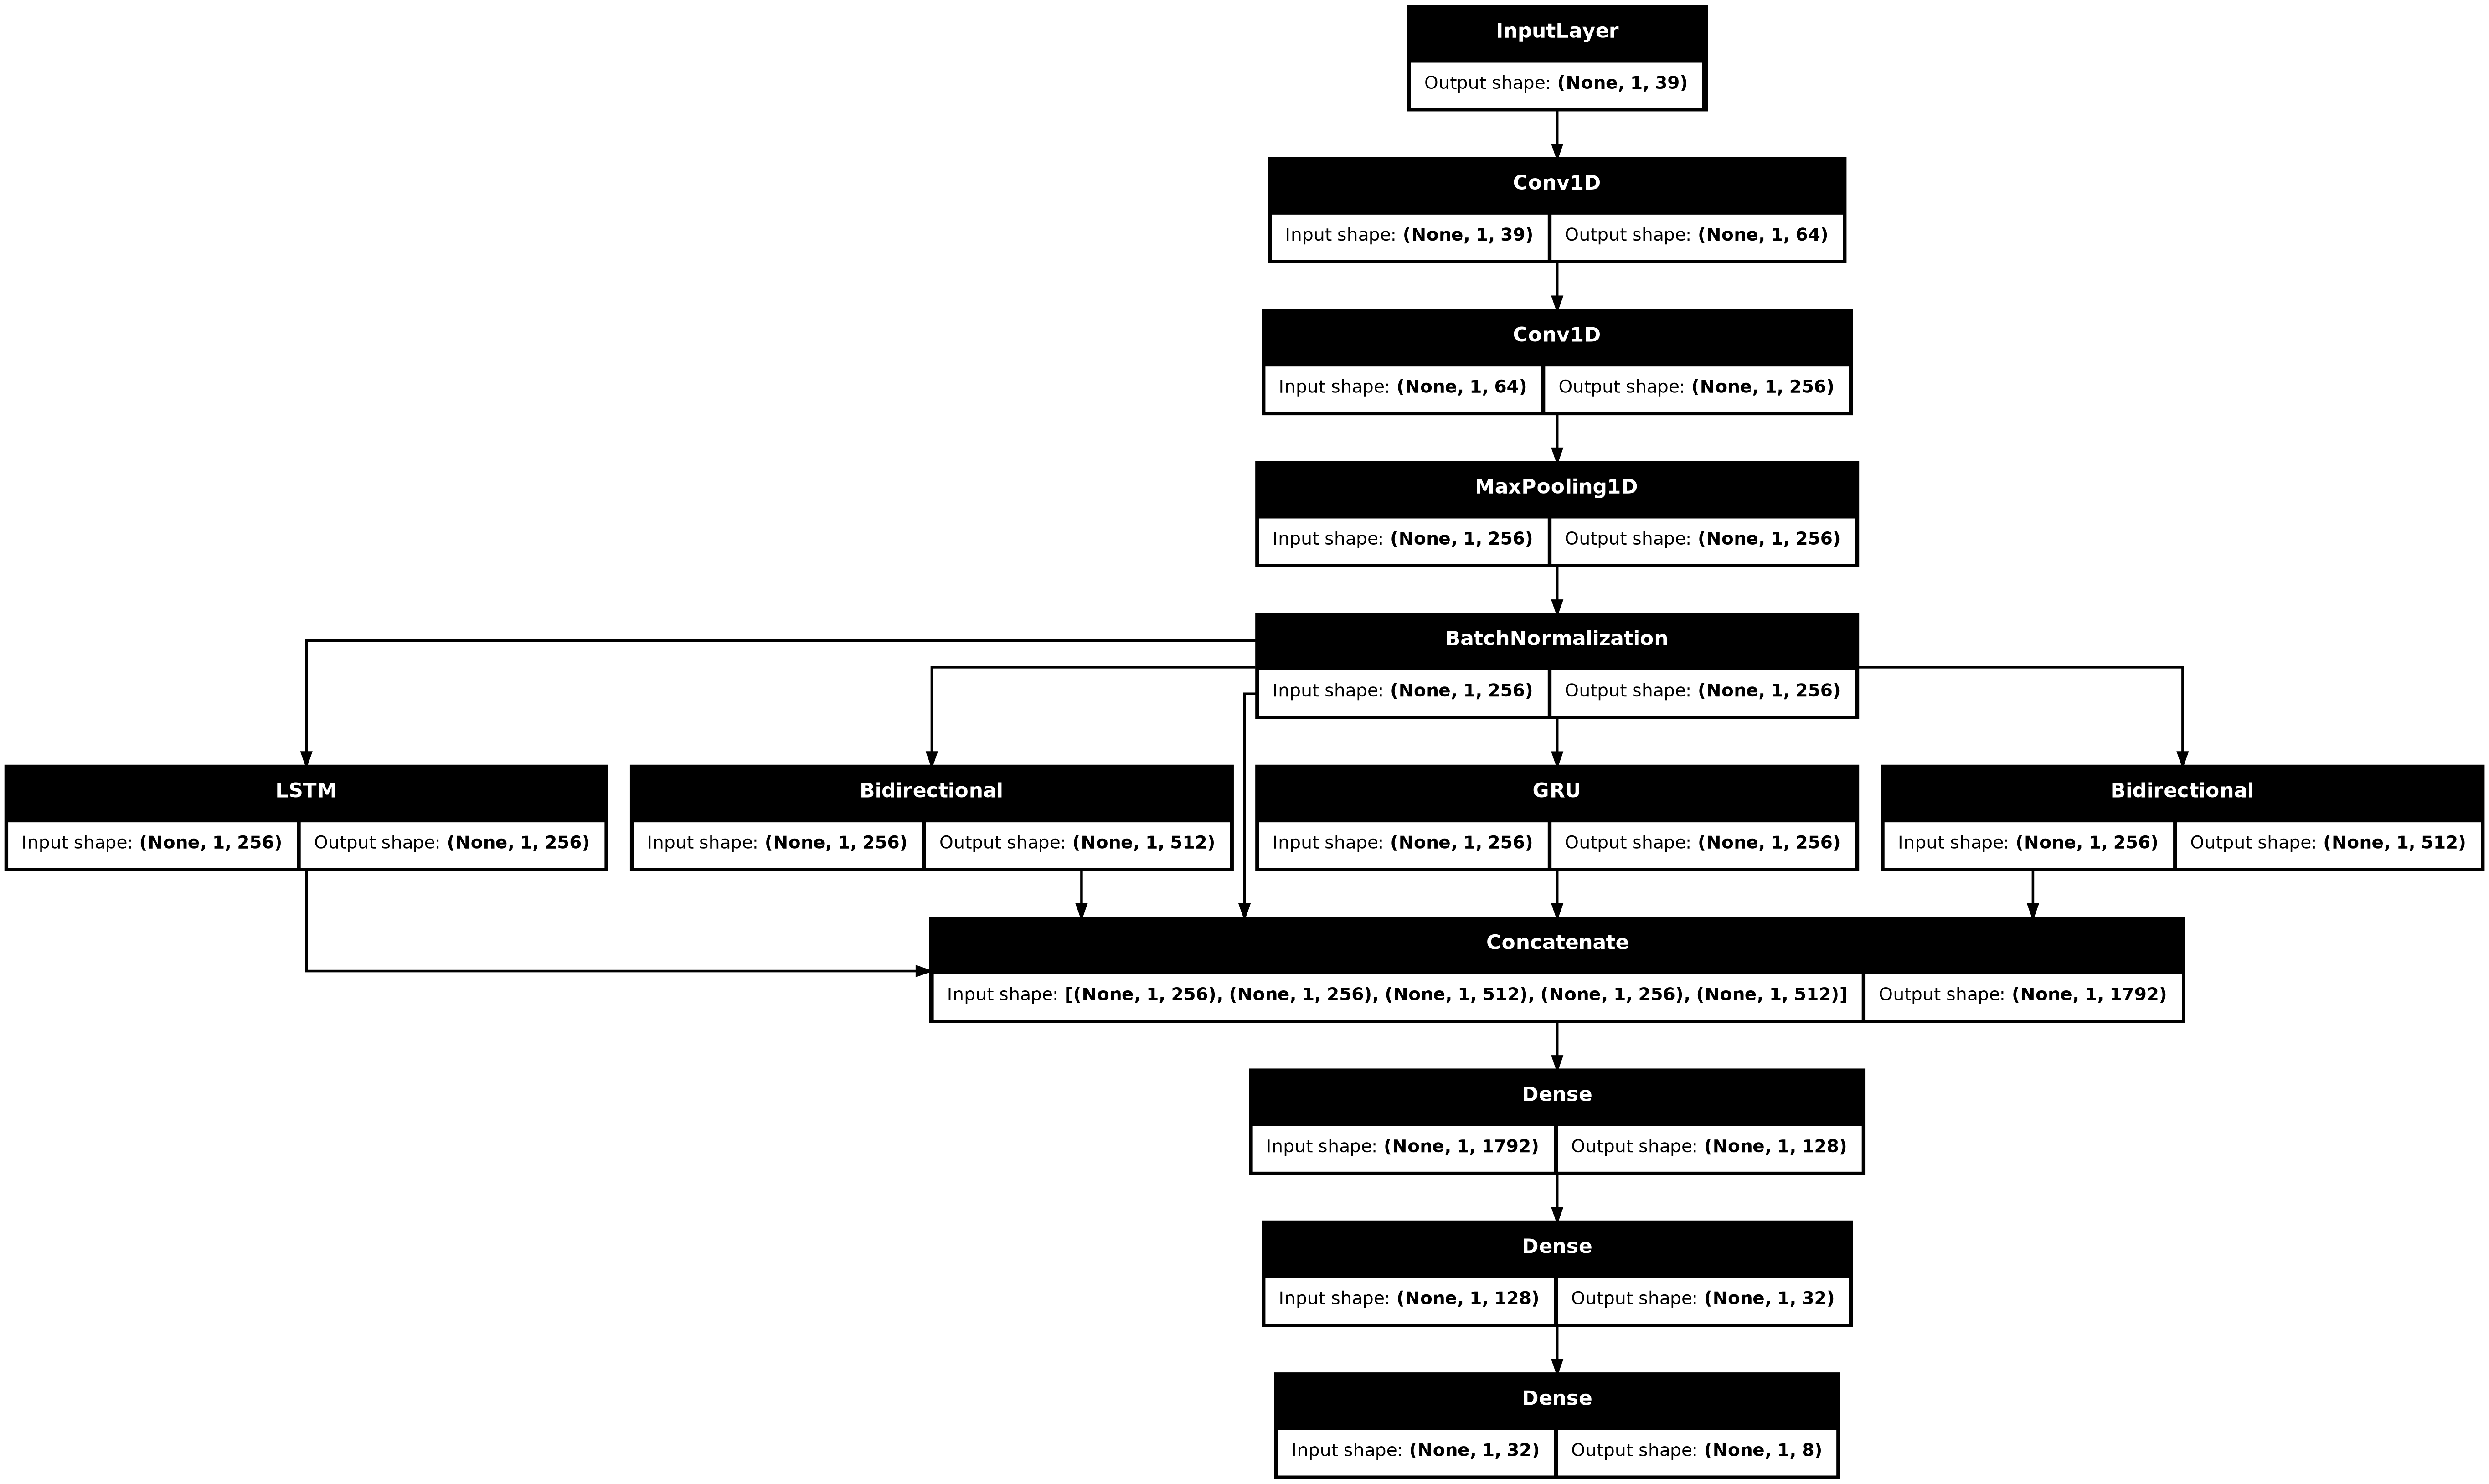

In [25]:
tf.keras.utils.plot_model(Respi_model, "Respi_model.png", show_shapes=True)

In [26]:
optimiser = Adam(learning_rate = 0.0005)
Respi_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [EarlyStopping(patience=250,monitor='accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("modelchkpnts/Respi_model.keras",save_best_only=True),
      TensorBoard(log_dir = "tnsrbrdlogs", histogram_freq=1)]

In [27]:
hist = Respi_model.fit(mfcc_train, labels_train, validation_data=(mfcc_val, labels_val),batch_size = 8, epochs=200, callbacks=callbacks)

Epoch 1/200


I0000 00:00:1746796429.917684   41490 cuda_dnn.cc:529] Loaded cuDNN version 90300


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3543 - loss: 1.7286

2025-05-09 13:14:11.578558: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62914560 exceeds 10% of free system memory.
2025-05-09 13:14:11.615969: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62914560 exceeds 10% of free system memory.
2025-05-09 13:14:11.659344: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62914560 exceeds 10% of free system memory.
2025-05-09 13:14:11.697105: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62914560 exceeds 10% of free system memory.
2025-05-09 13:14:11.740361: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62914560 exceeds 10% of free system memory.


98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.3549 - loss: 1.7271 - val_accuracy: 0.1034 - val_loss: 2.6424
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5626 - loss: 1.2109 - val_accuracy: 0.3333 - val_loss: 2.2982
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.5790 - loss: 1.1229 - val_accuracy: 0.4828 - val_loss: 1.4328
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5675 - loss: 1.0832 - val_accuracy: 0.4368 - val_loss: 2.0219
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5760 - loss: 1.0561 - val_accuracy: 0.4828 - val_loss: 1.7882
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5811 - loss: 1.0446 - val_accuracy: 0.4483 - val_loss: 2.3874
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6391 - loss: 1.0270 - val_accuracy: 0.5402 - val_loss: 1.4775
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6224 - loss: 1.0216 - val_accuracy: 0.4713 - val_

In [28]:
Respi_model.save("Respi_model.keras")

In [ ]:
# %tensorboard --logdir tnsrbrdlogs/ # <-- uncomment to load tensorboard

### Evaluation and Plots

In [34]:
def losscalc():
    m = Respi_model.evaluate(mfcc_train, labels_train)
    print("Training Loss: " + "%.3f" %m[0] + " Training Accuracy: " + "%.3f" %m[1])
    m = Respi_model.evaluate(mfcc_val, labels_val)
    print("Validation Loss: " + "%.3f" %m[0] + " Validation Accuracy: " + "%.3f" %m[1])
    m = Respi_model.evaluate(mfcc_test, labels_test)
    print("Testing Loss: " + "%.3f" %m[0] + " Testing Accuracy: " + "%.3f" %m[1])

losscalc()

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9222 - loss: 0.1842
Training Loss: 0.213 Training Accuracy: 0.914
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8067 - loss: 0.5616
Validation Loss: 0.588 Validation Accuracy: 0.793
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9440 - loss: 0.1626
Testing Loss: 0.145 Testing Accuracy: 0.948


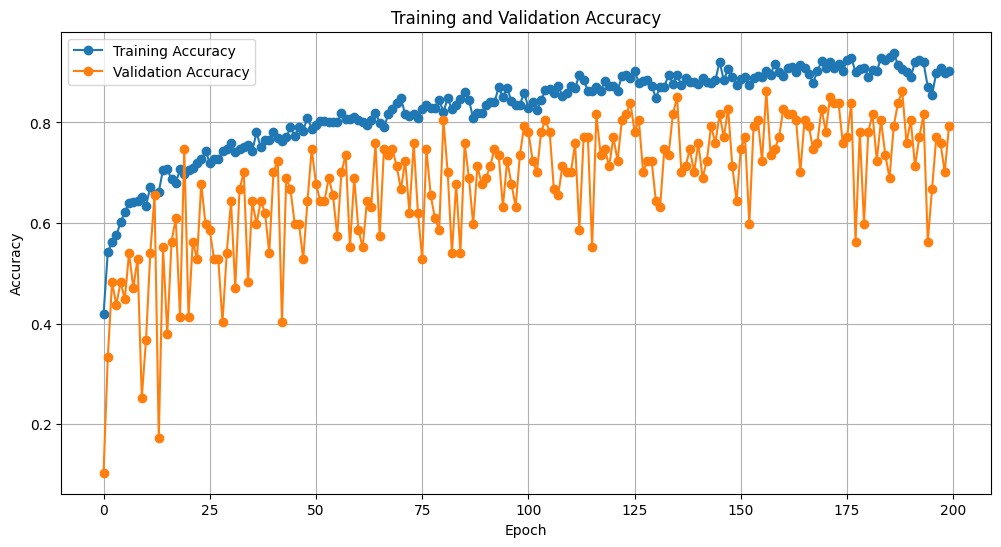

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("Respi_Model_training_plot.png")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


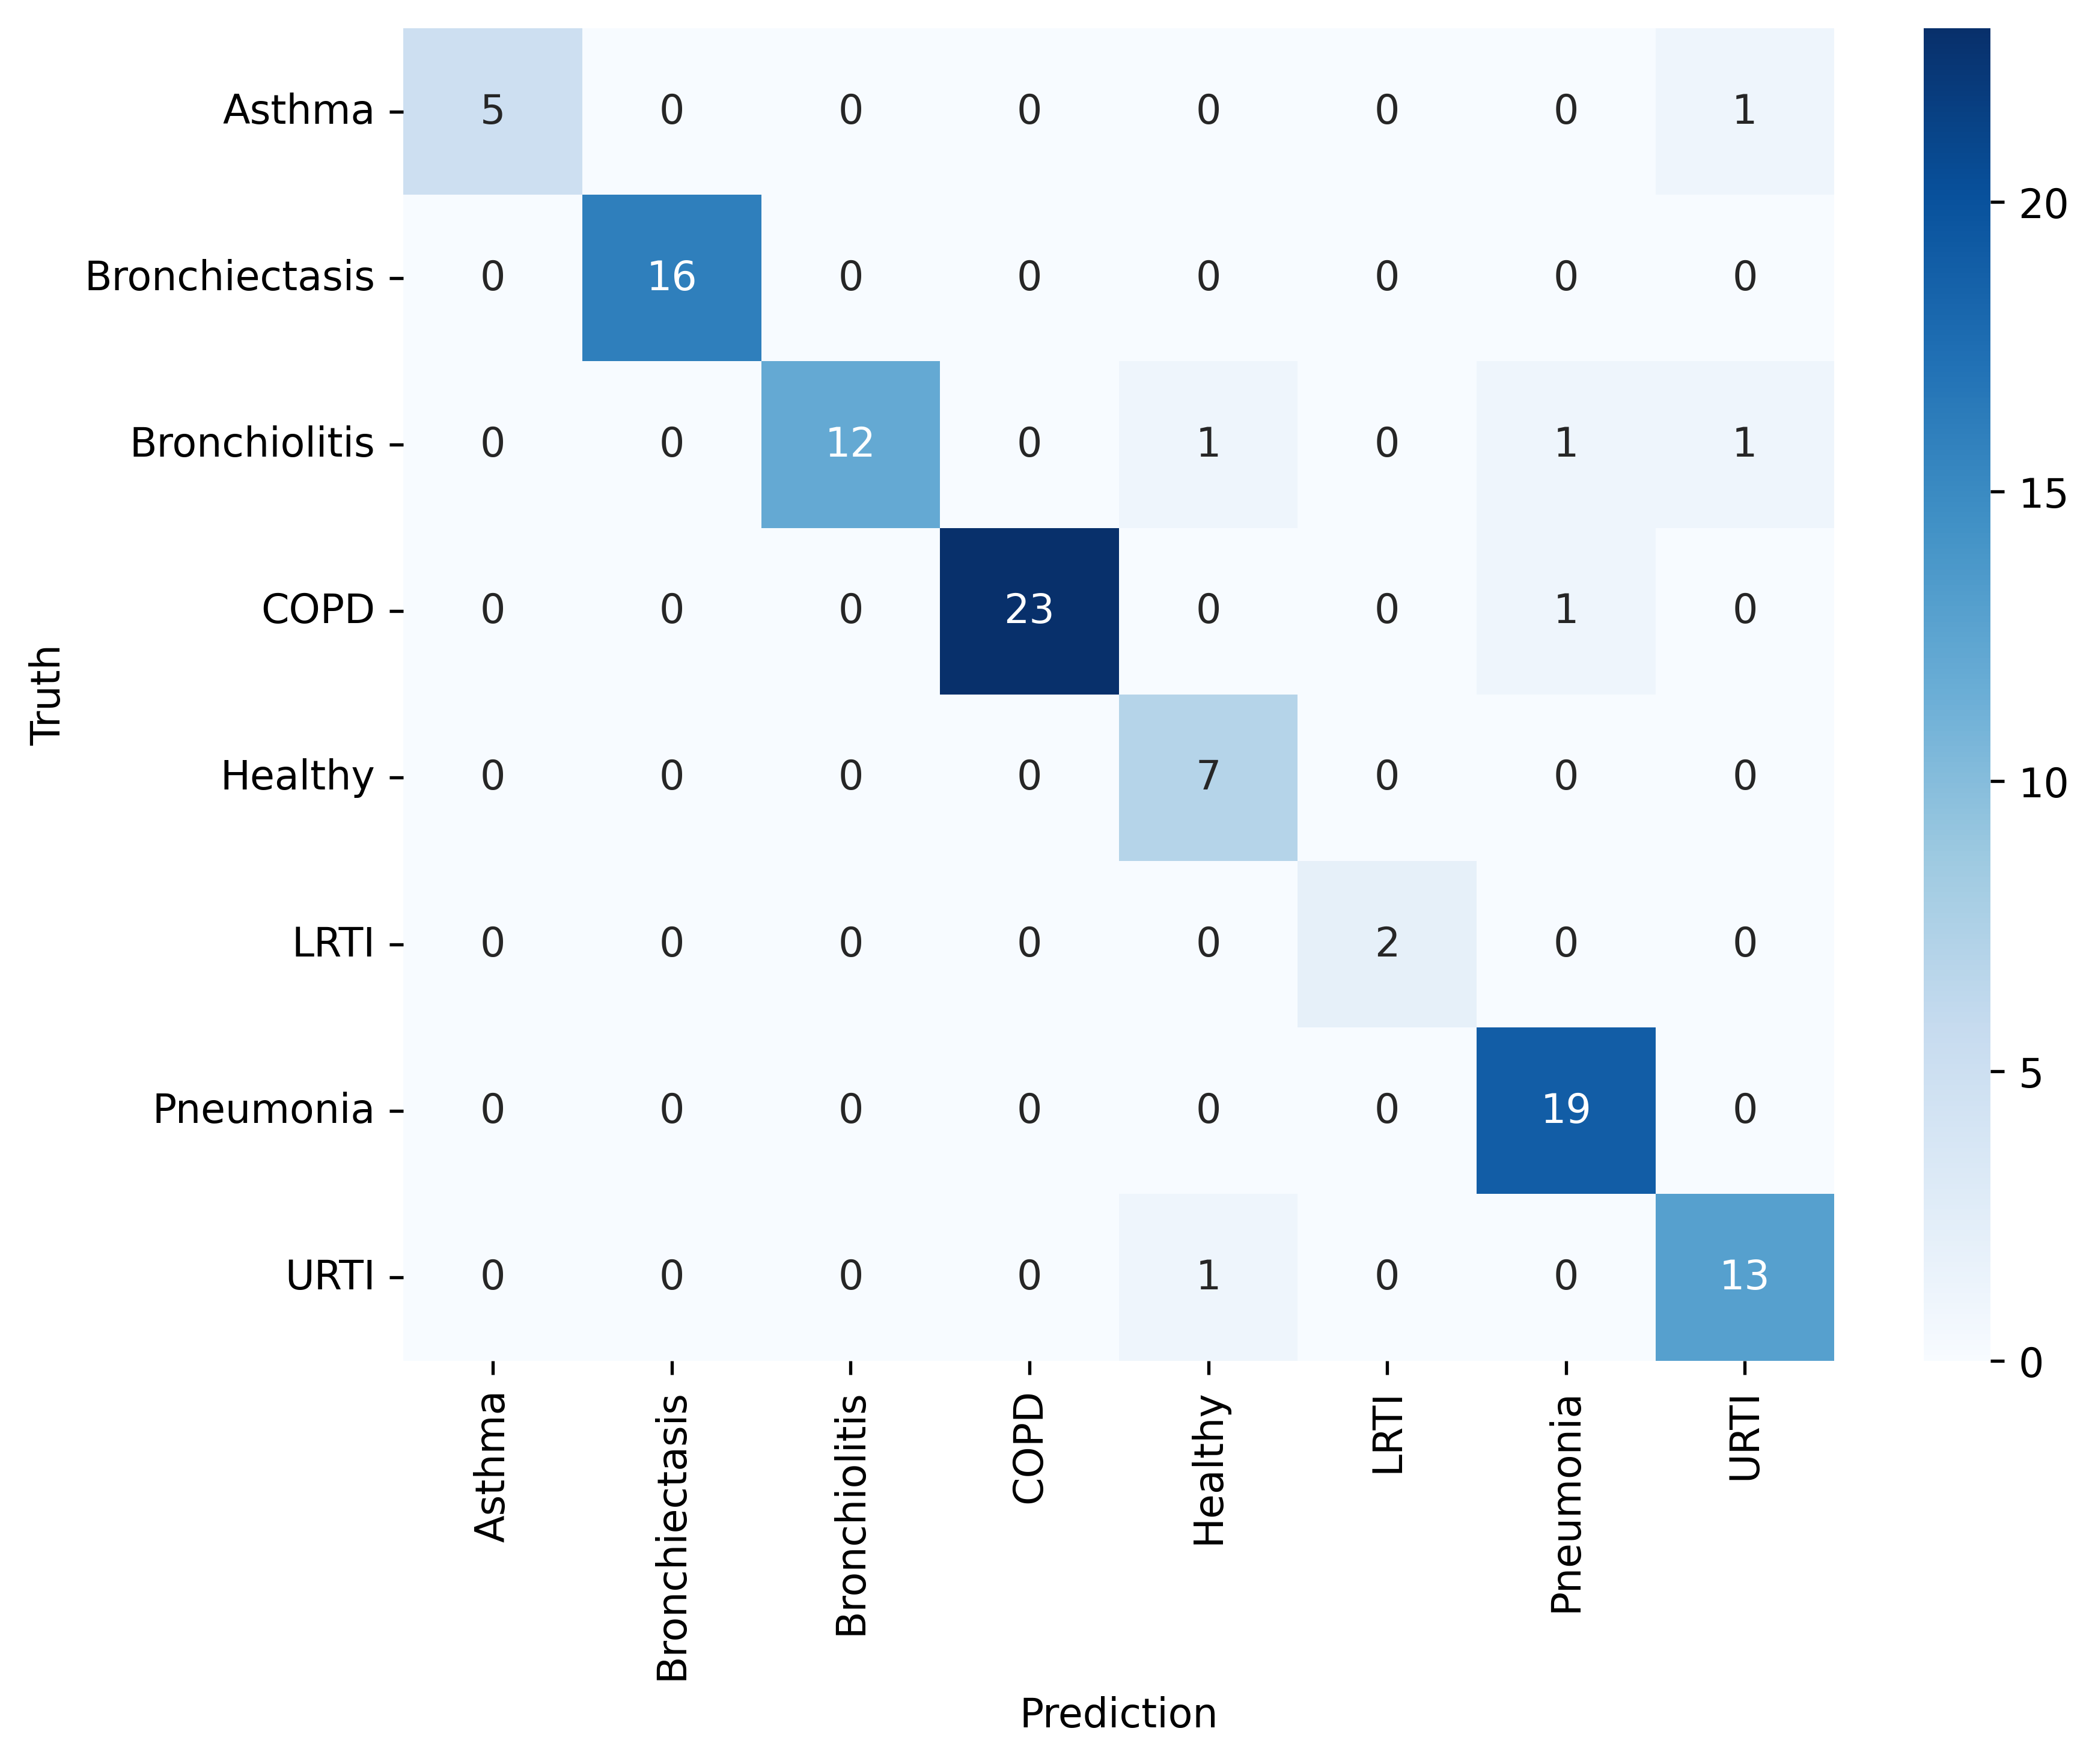

                precision    recall  f1-score   support

        Asthma       1.00      0.83      0.91         6
Bronchiectasis       1.00      1.00      1.00        16
 Bronchiolitis       1.00      0.80      0.89        15
          COPD       1.00      0.96      0.98        24
       Healthy       0.78      1.00      0.88         7
          LRTI       1.00      1.00      1.00         2
     Pneumonia       0.90      1.00      0.95        19
          URTI       0.87      0.93      0.90        14

      accuracy                           0.94       103
     macro avg       0.94      0.94      0.94       103
  weighted avg       0.95      0.94      0.94       103



In [90]:
def findtestingCM():
    classes = class_names
    preds = Respi_model.predict(mfcc_test)
    classpreds = [np.argmax(t) for t in preds ]
    y_testclass = [np.argmax(t) for t in labels_test]
    cm = confusion_matrix(y_testclass, classpreds)
    plt.figure(figsize=(8, 6), dpi=480, facecolor='w', edgecolor='k')
    ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig("Testing_CM.png")
    plt.show(ax)
    
    print(classification_report(y_testclass, classpreds,target_names=classes))

findtestingCM()

### Audio Detection setup

In [1]:
import tensorflow as tf
import numpy as np
import joblib
import librosa
import os

class_names = joblib.load("class_names.pkl")
features_extract = joblib.load("features.pkl")
Respi_model = tf.keras.models.load_model("Respi_model.keras")

2025-05-09 14:49:25.664771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746802165.679331   64303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746802165.683548   64303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 14:49:25.699186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1746802173.388055   64303 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17

In [3]:
def predict_class(audio_file_path, model, classes, features=features_extract, soundDir=''):
    val = []
    data_x, sampling_rate = librosa.load(audio_file_path + soundDir)
    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
    val.append(mfccs)
    val = np.expand_dims(val, axis=1)
    preds = model.predict(val)
    prediction = classes[np.argmax(preds[0], axis=1)[0]]
    confidence = preds.T[preds[0].mean(axis=0).argmax()].mean()
    print(prediction, confidence)


testlist = os.listdir('testdata')
for i in testlist:
    print(i)
    predict_class(f"testdata/{i}", Respi_model, class_names)
    print(" ")


9 May, 20.23​.m4a


/tmp/ipykernel_64303/1224206175.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir)
/home/sidthechillguy/miniconda3/envs/tensorflow/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
URTI 0.9553296
 
asthma.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Asthma 0.9974591
 
bronchiectasis.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Bronchiectasis 1.0
 
Bronchiolitis.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Pneumonia 0.3654027
 
copd.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
COPD 0.9995865
 
healthy.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Healthy 0.6923974
 
lrti.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LRTI 0.999003
 
pneumonia.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Pneumonia 0.7918746
 
urti.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
URTI 0.9288053
 
